Running on: cpu
Starting Training...
Epoch 1000/15000 | Loss: 0.025430 | Time: 18.5s
Epoch 2000/15000 | Loss: 0.025014 | Time: 37.2s
Epoch 3000/15000 | Loss: 0.002310 | Time: 55.4s
Epoch 4000/15000 | Loss: 0.009508 | Time: 74.6s
Epoch 5000/15000 | Loss: 0.014675 | Time: 92.6s
Epoch 6000/15000 | Loss: 0.000426 | Time: 112.5s
Epoch 7000/15000 | Loss: 0.000265 | Time: 130.6s
Epoch 8000/15000 | Loss: 0.000179 | Time: 149.7s
Epoch 9000/15000 | Loss: 0.000221 | Time: 168.2s
Epoch 10000/15000 | Loss: 0.000111 | Time: 186.9s
Epoch 11000/15000 | Loss: 0.000116 | Time: 205.3s
Epoch 12000/15000 | Loss: 0.003054 | Time: 223.5s
Epoch 13000/15000 | Loss: 0.000053 | Time: 242.3s
Epoch 14000/15000 | Loss: 0.000415 | Time: 260.3s
Epoch 15000/15000 | Loss: 0.000150 | Time: 279.1s
Training Complete.


/tmp/ipython-input-222446917.py:174: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  b_n = (2.0 / L) * np.trapz(ic_quad * sin_vals_quad, x_quad)



✓ Results saved to 'pinn_improved_results.png'
✓ Loss curve saved to 'pinn_loss_curve.png'


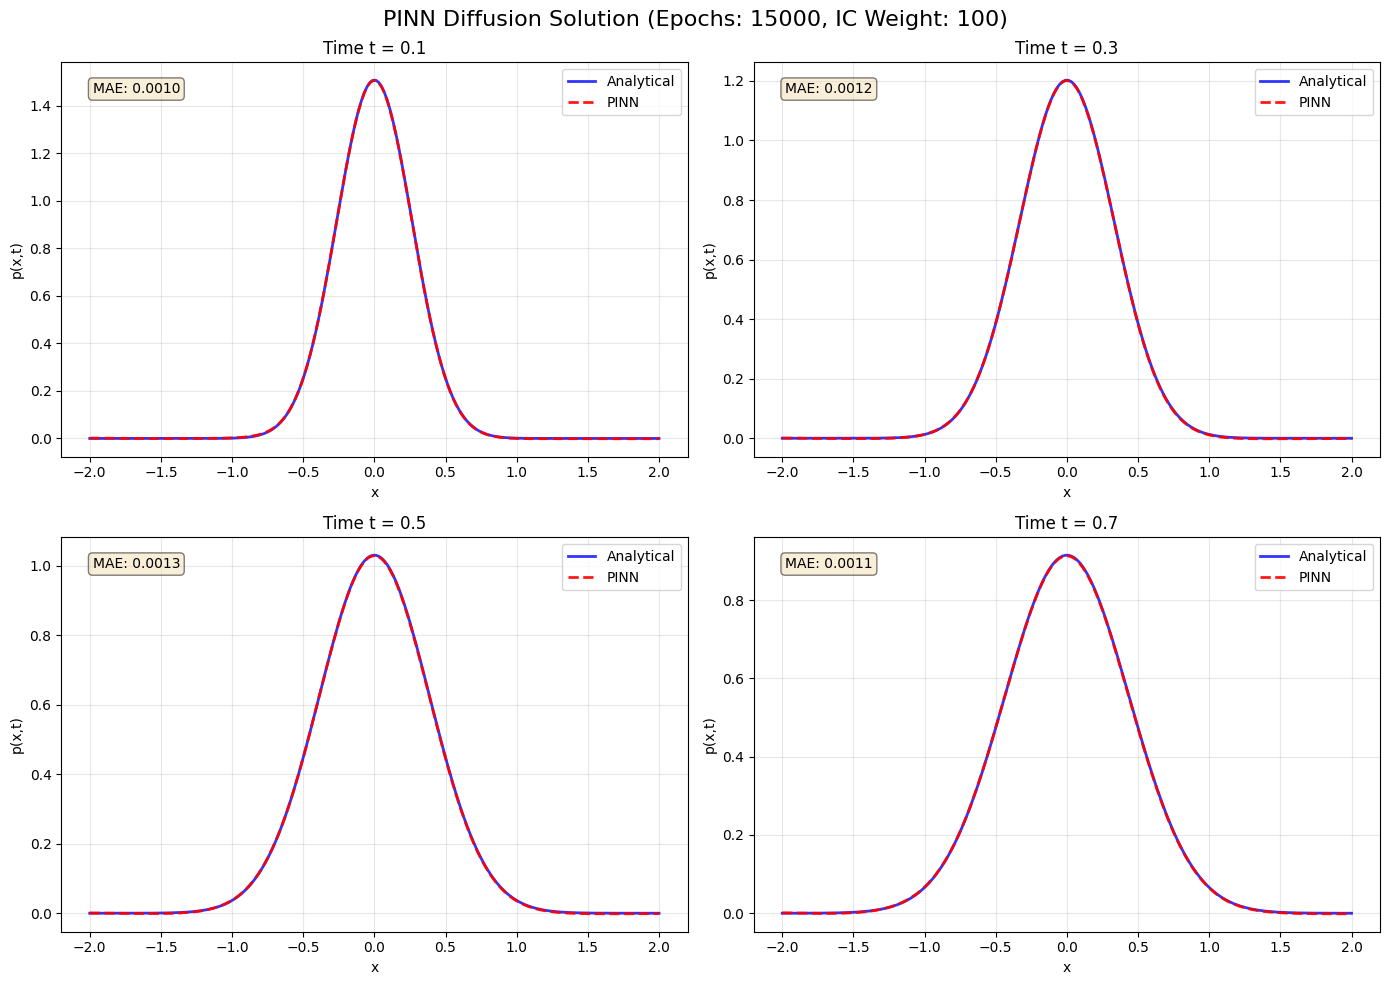

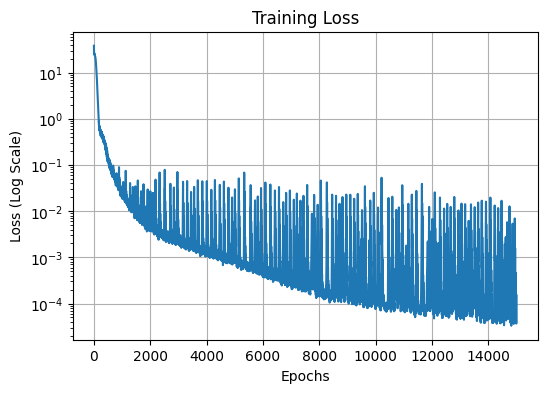

In [1]:
"""
PINN for 1D Diffusion
Solves: ∂p/∂t = D ∂²p/∂x²
on domain x ∈ [-2, 2], t ∈ [0, 1]
with Dirichlet BCs: p(-2,t) = p(2,t) = 0
and a Gaussian initial condition.
"""

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

# ============================================================================
# Configuration
# ============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

D = 0.1           # Diffusion coefficient
SIGMA_SQ = 0.05   # Variance of initial Gaussian
EPOCHS = 15000    # Training epochs
LR = 1e-3         # Learning rate

# Domain bounds
X_MIN, X_MAX = -2.0, 2.0
L = X_MAX - X_MIN  # Domain length = 4.0

print(f"Running on: {device}")

# ============================================================================
# PINN Architecture
# ============================================================================
class PhysicsInformedNN(nn.Module):
    """
    PINN: 3 hidden layers, 64 neurons each.
    Increased capacity allows capturing sharper gradients.
    """
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

# ============================================================================
# Loss Calculation
# ============================================================================
model = PhysicsInformedNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


def get_collocation_points(n_points):
    """
    Smart Sampling:
    Mixes uniform sampling with Gaussian sampling to focus on the center
    where the dynamics change most rapidly.
    """
    # 50% Uniform points
    x_uni = torch.rand(n_points // 2, 1, device=device) * L + X_MIN

    # 50% Gaussian distributed points near x=0 (focus on the peak)
    x_gauss = torch.randn(n_points // 2, 1, device=device) * 0.5
    x_gauss = torch.clamp(x_gauss, X_MIN, X_MAX)

    x = torch.cat([x_uni, x_gauss], dim=0).requires_grad_(True)
    t = torch.rand(n_points, 1, requires_grad=True, device=device)

    return x, t


def loss_function():
    # 1. PDE Residual (Interior)
    x, t = get_collocation_points(1000)
    p = model(x, t)

    p_t = torch.autograd.grad(p, t, torch.ones_like(p), create_graph=True)[0]
    p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
    p_xx = torch.autograd.grad(p_x, x, torch.ones_like(p_x), create_graph=True)[0]

    pde_loss = torch.mean((p_t - D * p_xx) ** 2)

    # 2. Boundary Conditions: p(-2, t) = 0,  p(2, t) = 0
    t_bc = torch.rand(100, 1, device=device)
    p_left = model(torch.full((100, 1), X_MIN, device=device), t_bc)
    p_right = model(torch.full((100, 1), X_MAX, device=device), t_bc)
    bc_loss = torch.mean(p_left ** 2 + p_right ** 2)

    # 3. Initial Condition: Gaussian at t=0
    x_ic = torch.linspace(X_MIN, X_MAX, 200).view(-1, 1).to(device)
    t_ic = torch.zeros_like(x_ic)

    p_pred_ic = model(x_ic, t_ic)
    # Normalized Gaussian IC (zero at boundaries for this narrow sigma)
    exact_ic = torch.exp(-x_ic ** 2 / (2 * SIGMA_SQ)) / np.sqrt(2 * np.pi * SIGMA_SQ)
    ic_loss = torch.mean((p_pred_ic - exact_ic) ** 2)

    # Weighted Sum: Heavy penalty on IC to force peak learning
    return pde_loss + 10 * bc_loss + 100 * ic_loss


# ============================================================================
# Training Loop
# ============================================================================
print("Starting Training...")
start_time = time.time()
loss_history = []

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    loss = loss_function()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 1000 == 0:
        elapsed = time.time() - start_time
        print(f"Epoch {epoch + 1}/{EPOCHS} | Loss: {loss.item():.6f} | Time: {elapsed:.1f}s")

print("Training Complete.")


# ============================================================================
# Analytical Solution (Eigenfunction Expansion)
# ============================================================================
def analytical_solution(x, t, n_terms=200, n_quad=2000):
    """
    Exact solution on [-2, 2] with p = 0 Dirichlet BCs.

    We shift the domain to [0, L] for the standard sine-series formulation:
        x_shifted = x - X_MIN        (maps [-2,2] -> [0,4])

    The solution is:
        p(x, t) = Σ  b_n  sin(n π x_s / L)  exp(-D (n π / L)² t)

    where x_s = x_shifted, and the Fourier sine coefficients are:
        b_n = (2/L) ∫₀ᴸ  f(x_s)  sin(n π x_s / L)  dx_s

    and f is the initial condition expressed in shifted coordinates:
        f(x_s) = (1/√(2π σ²)) exp(-(x_s - L/2)² / (2 σ²))
    """
    x_shifted = x - X_MIN                          # shift to [0, L]
    x_quad = np.linspace(0, L, n_quad)             # quadrature grid for b_n
    ic_quad = (1.0 / np.sqrt(2 * np.pi * SIGMA_SQ)) * \
              np.exp(-(x_quad - L / 2) ** 2 / (2 * SIGMA_SQ))  # IC on [0, L]

    p = np.zeros_like(x)

    for n in range(1, n_terms + 1):
        sin_vals_quad = np.sin(n * np.pi * x_quad / L)
        # Fourier sine coefficient via numerical integration
        b_n = (2.0 / L) * np.trapz(ic_quad * sin_vals_quad, x_quad)

        # Spatial basis evaluated at test points
        sin_vals_x = np.sin(n * np.pi * x_shifted / L)
        # Temporal decay
        decay = np.exp(-D * (n * np.pi / L) ** 2 * t)

        p += b_n * sin_vals_x * decay

    return p


# ============================================================================
# Visualization & Validation
# ============================================================================
model.eval()
x_test = np.linspace(X_MIN, X_MAX, 200)
times = [0.1, 0.3, 0.5, 0.7]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, t_val in enumerate(times):
    # --- PINN Prediction ---
    x_torch = torch.from_numpy(x_test).float().reshape(-1, 1).to(device)
    t_torch = torch.full((200, 1), t_val, device=device)

    with torch.no_grad():
        p_pred = model(x_torch, t_torch).cpu().numpy().flatten()

    # --- Analytical Solution (eigenfunction expansion, matches BCs) ---
    p_exact = analytical_solution(x_test, t_val)

    # --- Plotting ---
    axes[idx].plot(x_test, p_exact, 'b-', linewidth=2, label='Analytical', alpha=0.8)
    axes[idx].plot(x_test, p_pred, 'r--', linewidth=2, label='PINN', alpha=0.9)

    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('p(x,t)')
    axes[idx].set_title(f'Time t = {t_val}')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

    # Calculate & display MAE
    mae = np.mean(np.abs(p_pred - p_exact))
    axes[idx].text(0.05, 0.95, f'MAE: {mae:.4f}',
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f"PINN Diffusion Solution (Epochs: {EPOCHS}, IC Weight: 100)", fontsize=16)
plt.tight_layout()
plt.savefig('pinn_improved_results.png', dpi=150)
print("\n✓ Results saved to 'pinn_improved_results.png'")

# --- Loss Curve ---
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.yscale('log')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log Scale)')
plt.grid(True)
plt.savefig('pinn_loss_curve.png')
print("✓ Loss curve saved to 'pinn_loss_curve.png'")